In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 21 00:12:59 2022

@author: hassa
"""
import numpy as np
import scipy as sp
import scipy.special
import numpy as np
import math
import matplotlib.pyplot as plt


import warnings

from matplotlib import pyplot as plt
from few.trajectory.inspiral import EMRIInspiral
from few.utils.baseclasses import SchwarzschildEccentric, Pn5AAK, ParallelModuleBase, KerrCircular
from few.waveform import FastSchwarzschildEccentricFlux, AAKWaveformBase, Pn5AAKWaveform, SlowSchwarzschildEccentricFlux, KerrCircularFlux, MigrationTorqueKerrCircularFlux, ScalarCloudKerrCircularFlux

from few.summation.aakwave import AAKSummation
from few.utils.utility import get_mismatch
from few.waveform import   GenerateEMRIWaveform
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi
from few.waveform import SchwarzschildEccentricWaveformBase, RelativisticKerrCircularWaveformBase
from few.utils.baseclasses import SchwarzschildEccentric
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.interp2dcubicspline import Interp2DAmplitude, Interp2DAmplitudeKerrCircular
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant, InterpolatedModeSumKerrCircular
from few.summation.directmodesum import DirectModeSum
from few.utils.ylm import GetYlms
from few.amplitude.romannet import RomanAmplitude

try:
    import cupy as xp

    gpu_available = True

except (ModuleNotFoundError, ImportError) as e:
    import numpy as xp

    warnings.warn(
        "CuPy is not installed or a gpu is not available. If trying to run on a gpu, please install CuPy."
    )
    gpu_available = False


traj_few = EMRIInspiral(func="SchwarzEccFlux")
print("old few traj loaded",traj_few,"\n")

traj_Kerr = EMRIInspiral(func="KerrCircFlux")
print("Kerr traj loaded",traj_Kerr,"\n")


traj_migration = EMRIInspiral(func="MigTorqKerrCircFlux")
print("Migration traj loaded",traj_migration,"\n")

traj_cloud = EMRIInspiral(func="CloudKerrCircFlux")
print("Cloud traj loaded",traj_cloud,"\n")

T = 4.0 # years
dt = 10.0
# set initial parameters
M = 1e6
mu = 5e1
p0 = 10.0
e0 = 0.0
a0 = 0.8
x0 = 1.0
Y0 = 1.0


# sample values for migration params
A = 1e-5
nr = 8

# a sample value for the cloud
alpha =  0.16
Mb_M = 0.05



Kerr_result = traj_Kerr(M,mu,a0,p0,e0,Y0,T=T, dt=dt)
migration_result = traj_migration(M,mu,a0,p0,e0,Y0,A, nr,T=T, dt=dt)
cloud_result = traj_cloud(M,mu,a0,p0,e0,Y0,alpha,Mb_M,T=T, dt=dt)

t_Kerr  = Kerr_result[0]
t_migration = migration_result[0]
t_cloud = cloud_result[0]
print("Kerr final time: ", t_Kerr[-1], "Migration final time: ", t_migration[-1], "Cloud final time: ", t_cloud[-1])


p_Kerr = Kerr_result[1]
p_migration = migration_result[1]
p_cloud = cloud_result[1]
print("Kerr final p: ", p_Kerr[-1], "Migration final p: ", p_migration[-1], "Cloud final p: ", p_cloud[-1])


old few traj loaded <few.trajectory.inspiral.EMRIInspiral object at 0x7fe8f266c440> 

Kerr traj loaded <few.trajectory.inspiral.EMRIInspiral object at 0x7fe8f1d59a90> 

Migration traj loaded <few.trajectory.inspiral.EMRIInspiral object at 0x7fe8f1d59e50> 

Cloud traj loaded <few.trajectory.inspiral.EMRIInspiral object at 0x7fe8f2786d70> 

Kerr final time:  21265231.425755847 Migration final time:  21265144.506286032 Cloud final time:  21265517.02409242
Kerr final p:  3.006643863029135 Migration final p:  3.0066438632697814 Cloud final p:  3.0066438633371293


/tmp/ipykernel_22478/1160658339.py:44: UserWarning: CuPy is not installed or a gpu is not available. If trying to run on a gpu, please install CuPy.
  warnings.warn(


# Waveform Example

In [2]:

use_gpu = gpu_available #change this to True for gpu
import multiprocessing

num_threads = multiprocessing.cpu_count()



# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e4),  # this must be >= batch_size
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu  # GPU is available for this type of summation
}



Kerr_inspiral_kwargs={
    "err": 1e-12,
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e7),  # dense stepping trajectories
    "func": "KerrCircFlux"
    }





gen_wave_Kerr = GenerateEMRIWaveform(
RelativisticKerrCircularWaveformBase, # Define the base waveform
EMRIInspiral, # Define the trajectory
Interp2DAmplitudeKerrCircular, # Define the interpolation for the amplitudes
InterpolatedModeSumKerrCircular, # Define the type of summation
inspiral_kwargs=Kerr_inspiral_kwargs,
sum_kwargs=sum_kwargs,
amplitude_kwargs=amplitude_kwargs,
use_gpu=use_gpu,
frame='detector'
)


Rel_Kerr = KerrCircularFlux(num_threads=num_threads, use_gpu=use_gpu)
Rel_Kerr_migration = MigrationTorqueKerrCircularFlux(num_threads=num_threads, use_gpu=use_gpu)
Rel_Kerr_cloud = ScalarCloudKerrCircularFlux(num_threads=num_threads, use_gpu=use_gpu)


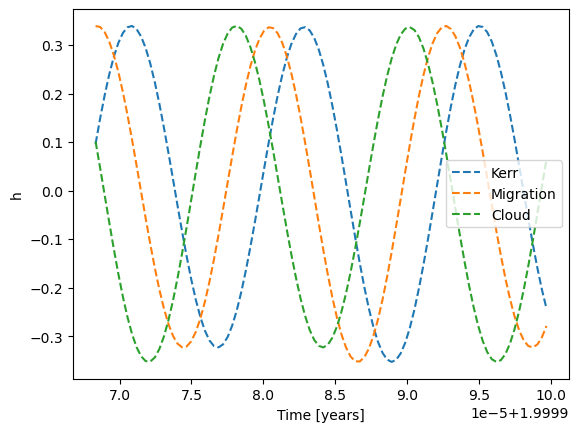

In [8]:




T = 2.0 # years
dt = 10.0 #10.0
# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.0
a0 = 0.99
x0 = 1.0
Y0 = 1.0
theta = 0.6
phi = 1.2
dist  = 1.0
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0


# sample values for migration params
A = 1e-5
nr = 8

# a sample value for the cloud
alpha =  0.16
Mb_M = 0.05




lmax = 2
specific_modes = []
for l in range(2,lmax+1):
    for m in range(0,l+1):
        specific_modes += [(l,m,0)]

Kerr_wave = Rel_Kerr(M, mu, a0, p0, e0, theta, phi, dist, dt=dt,T = T, mode_selection=specific_modes)
migration_wave = Rel_Kerr_migration(M, mu, a0, p0, e0, theta, phi, A, nr, dist, dt=dt,T = T, mode_selection=specific_modes)
cloud_wave = Rel_Kerr_cloud(M, mu, a0, p0, e0, theta, phi,alpha, Mb_M,  dist, dt=dt,T = T, mode_selection=specific_modes)

t_kerr  = np.arange(0, len(Kerr_wave))*dt/YRSID_SI
t_migration = np.arange(0, len(migration_wave))*dt/YRSID_SI
t_cloud = np.arange(0, len(cloud_wave))*dt/YRSID_SI



plt.plot(t_kerr[-100:],Kerr_wave.real[-100:],'--', label = 'Kerr')
plt.plot(t_migration[-100:],migration_wave.real[-100:],'--', label = 'Migration')
plt.plot(t_cloud[-100:],cloud_wave.real[-100:],'--', label = 'Cloud')
plt.xlabel('Time [years]')
plt.ylabel('h')
plt.legend()